In [30]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

In [31]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

log_dir = f'../../../data-addition-dilemma/distance_data'

map_race = {'asian': 0, 
            'black': 1,
            'other': 2,
            'white': 3}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

In [32]:
def get_hospital(hid, split='train', max_samples=None, sample_ratio=1, rand_seed=42): 
    file_name =f'{hid}/data.npz'
    hos = np.load(os.path.join(log_dir, file_name), allow_pickle=True)
    x = hos[split].item()['features']
    y = hos[split].item()['labels']
    xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
    if sample_ratio < 1: 
        rng = np.random.default_rng(rand_seed)
        ind = rng.choice(len(x), size=int(len(x)*sample_ratio), replace=False)
        return x[ind], y[ind], xy[ind]
    elif max_samples is not None: 
        if len(x) > max_samples: 
            rng = np.random.default_rng(rand_seed)
            ind = rng.choice(len(x), size=int(max_samples), replace=False)
            return x[ind], y[ind], xy[ind]
        else: 
            return x, y, xy
    else: 
        return x, y, xy

## data quality heuristics

In [33]:
def compute_binary_subgroup_score(hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify black and white patients from each hospital'''
    
    results_x = np.zeros((len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids)))

    for i, hid in enumerate(hospital_ids):
        x, _, xy = get_hospital(hid, 'train', max_samples=num_samples)
        
        x_white = np.delete(x[x[:, -1] == 3.0], -1, axis=1)
        x_black = np.delete(x[x[:, -1] == 1.0], -1, axis=1)
        
        xy_white = np.delete(xy[xy[:, -2] == 3.0], -2, axis=1)
        xy_black = np.delete(xy[xy[:, -2] == 1.0], -2, axis=1)

        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1)
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

        X_train = np.concatenate((x_white, x_black), axis=0)
        Y_train = np.concatenate((np.ones(len(x_white)), np.zeros(len(x_black))), axis=0)

        pipe.fit(X_train, Y_train)

        x_val, _, xy_val = get_hospital(hid, 'test')
        
        x_val = x_val[(x_val[:, -1] == 1.0) | (x_val[:, -1] == 3.0)]
        xy_val = xy_val[(xy_val[:, -2] == 1.0) | (xy_val[:, -2] == 3.0)]
        
        y_val = x_val[:, -1]
        y_val = np.where(y_val == 3.0, 1, 0)
        
        x_val = np.delete(x_val, -1, axis=1)
        xy_val = np.delete(xy_val, -2, axis=1)

        y_prob = pipe.predict_proba(x_val)[:, 1]
        results_x[i] = roc_auc_score(y_val, y_prob)

        X_train = np.concatenate((xy_white, xy_black), axis=0)
        Y_train = np.concatenate((np.ones(len(xy_white)), np.zeros(len(xy_black))), axis=0)

        pipe.fit(X_train, Y_train)

        y_prob = pipe.predict_proba(xy_val)[:, 1]
        results_xy[i] = roc_auc_score(y_val, y_prob)

    return results_x, results_xy
    # save_dir = Path(save_dir)
    # with open(save_dir / 'subgroup-score-xy.npy', 'wb') as f:
    #     np.save(f, results_xy)

    # with open(save_dir / 'subgroup-score-x.npy', 'wb') as f:
    #     np.save(f, results_x)

In [34]:
binary_score_x, binary_score_xy = compute_binary_subgroup_score(hospital_ids, "")

In [35]:
def compute_multiclass_subgroup_score(hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify all patients from each hospital for multiclass logistic regression'''

    results_x = np.zeros((len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids)))

    for i, hid in enumerate(hospital_ids):
        x, _, xy = get_hospital(hid, 'train', max_samples=num_samples)
        
        # No need to filter for 1.0 or 3.0, keep all rows and all classes in the 'pred' column
        # Split into features (X_train) and target (Y_train) using the last column as the label
        X_train = np.delete(x, -1, axis=1)
        Y_train = x[:, -1]  # Multiclass target: 0.0, 1.0, 2.0, 3.0

        xy_train = np.delete(xy, -2, axis=1)
        Y_train_xy = xy[:, -2]  # Multiclass target for xy dataset

        # Create and fit the pipeline
        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class='multinomial', solver='lbfgs')
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

        # Train on the x set
        pipe.fit(X_train, Y_train)

        # Test the model
        x_val, _, xy_val = get_hospital(hid, 'test')
        
        # No need to filter for specific classes, keep all rows and use the full multiclass label set
        X_val = np.delete(x_val, -1, axis=1)
        Y_val = x_val[:, -1]  # Multiclass true labels for x set

        xy_val_features = np.delete(xy_val, -2, axis=1)
        Y_val_xy = xy_val[:, -2]  # Multiclass true labels for xy set

        # Predict probabilities for all classes
        y_prob_x = pipe.predict_proba(X_val)
        y_pred_x = pipe.predict(X_val)
        results_x[i] = accuracy_score(Y_val, y_pred_x)  # You can use accuracy for multiclass

        # Train on the xy set and evaluate
        pipe.fit(xy_train, Y_train_xy)

        y_prob_xy = pipe.predict_proba(xy_val_features)
        y_pred_xy = pipe.predict(xy_val_features)
        results_xy[i] = accuracy_score(Y_val_xy, y_pred_xy)

    return results_x, results_xy

In [36]:
multi_score_x, multi_score_xy = compute_multiclass_subgroup_score(hospital_ids, "")

In [ ]:
black_hosp_thresh_str = ["73", "188", "243", "300", "443", "458"]
black_hosp_thresh = [73, 188, 243, 300, 443, 458]
plot_df_black = plot_df[(plot_df['train_hospital'].isin(black_hosp_thresh_str)) & (plot_df['test_hospital'].isin(black_hosp_thresh))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


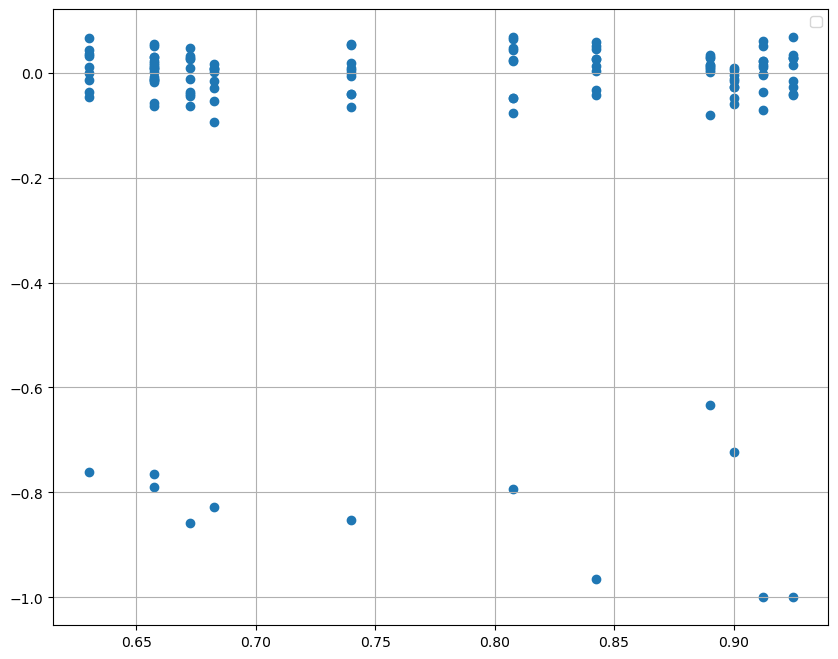

In [42]:
metric = "race1_AUC_TEST"

x = np.repeat(multi_score_xy, len(hospital_ids))
y = add_data_avg[metric].flatten() - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()

mask = y != 0

x_filtered = x[mask]
y_filtered = y[mask]

plt.figure(figsize=(10, 8))
plt.scatter(x_filtered, y_filtered)
plt.legend()
# plt.xlabel(f'{exp} of added hospital')
# plt.ylabel(f'{file}')
# plt.title(f'{subgroup}-{exp}')
plt.grid(True)

## inter-hospital similarities

In [8]:
def compute_binary_subgroup_score(subgroup: int, hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify SUBGROUP patients between a pair of hospitals'''
    
    results_x = np.zeros((len(hospital_ids), len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids), len(hospital_ids)))
    print("computing pairwise score distance function")
    for test_i, test_h in enumerate(hospital_ids):
        for i, h in enumerate(hospital_ids):
            hos = test_h
            if h != hos:
                x, _, xy = get_hospital(h, 'train', max_samples=num_samples)
                x2, _, xy2 = get_hospital(hos, 'train', max_samples=num_samples)
                
                x = np.delete(x[x[:, -1] == map_race[subgroup]], -1, axis=1)
                x2 = np.delete(x2[x2[:, -1] == map_race[subgroup]], -1, axis=1)
                
                xy = np.delete(xy[xy[:, -2] == map_race[subgroup]], -2, axis=1)
                xy2 = np.delete(xy2[xy2[:, -2] == map_race[subgroup]], -2, axis=1)
                
                scaler = StandardScaler()
                logistic = LogisticRegression(max_iter=10000, tol=0.1)
                pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

                X_train = np.concatenate((x, x2), axis=0)
                Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)

                pipe.fit(X_train, Y_train)

                x_val, _, _ = get_hospital(h, 'test')
                x_val = np.delete(x_val[x_val[:, -1] == map_race[subgroup]], -1, axis=1)
                
                results_x[i, test_i] = pipe.predict_proba(x_val)[:, 1].mean()

                X_train = np.concatenate((xy, xy2), axis=0)
                Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xy2))), axis=0)

                pipe.fit(X_train, Y_train)

                _, _, xy_val = get_hospital(h, 'test')
                xy_val = np.delete(xy_val[xy_val[:, -2] == map_race[subgroup]], -2, axis=1)
                results_xy[i, test_i] = pipe.predict_proba(xy_val)[:, 1].mean()

    save_dir = Path(save_dir)
    with open(save_dir / f'{subgroup}-score-xy.npy', 'wb') as f:
        np.save(f, results_xy)

    with open(save_dir / f'{subgroup}-score-x.npy', 'wb') as f:
        np.save(f, results_x)
        
    return results_x, results_xy

In [9]:
def plot_subgroup_score_heatmaps(plot_mat_x, plot_mat_xy, subgroup):
    fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
    
    vmin = np.sort(np.unique(plot_mat_x))[1]
            
    sns.heatmap(plot_mat_x, annot=True, cmap="rocket_r", ax=axes[0], 
                xticklabels=hospital_ids, 
            yticklabels=hospital_ids, vmin=vmin)
    axes[0].set_xlabel("Test Hospital")
    axes[0].set_ylabel("Train Hospital")
    axes[0].set_title("Scores_X")

    vmin = np.sort(np.unique(plot_mat_xy))[1]

    sns.heatmap(plot_mat_xy, annot=True, cmap="rocket_r", ax=axes[1], 
                xticklabels=hospital_ids, 
            yticklabels=hospital_ids, vmin=vmin)
    axes[1].set_xlabel("Test Hospital")
    axes[1].set_ylabel("Train Hospital")
    axes[1].set_title("Scores_XY")

    plt.suptitle(f"{subgroup} Subgroup Similarity Score across hospitals")

computing pairwise score distance function


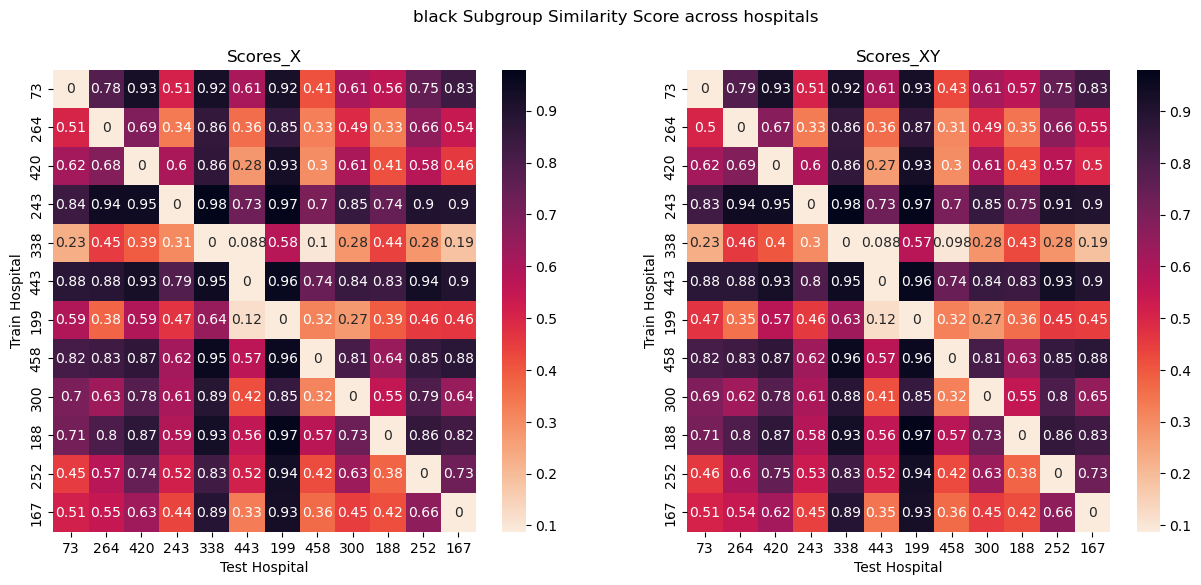

In [10]:
subgroup = "black"
results_x, results_xy = compute_binary_subgroup_score(subgroup, hospital_ids, "/home/tane/YAIB/YAIB/results/distances")

plot_subgroup_score_heatmaps(results_x, results_xy, subgroup)

computing pairwise score distance function


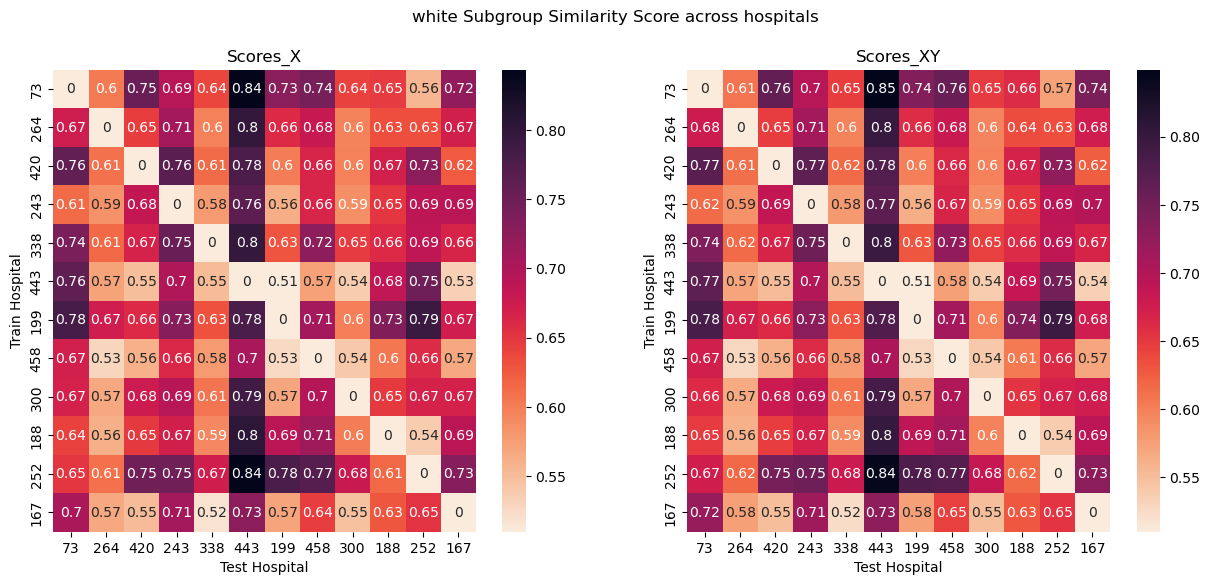

In [11]:
subgroup = "white"
results_x, results_xy = compute_binary_subgroup_score(subgroup, hospital_ids, "/home/tane/YAIB/YAIB/results/distances")

plot_subgroup_score_heatmaps(results_x, results_xy, subgroup)

computing pairwise score distance function


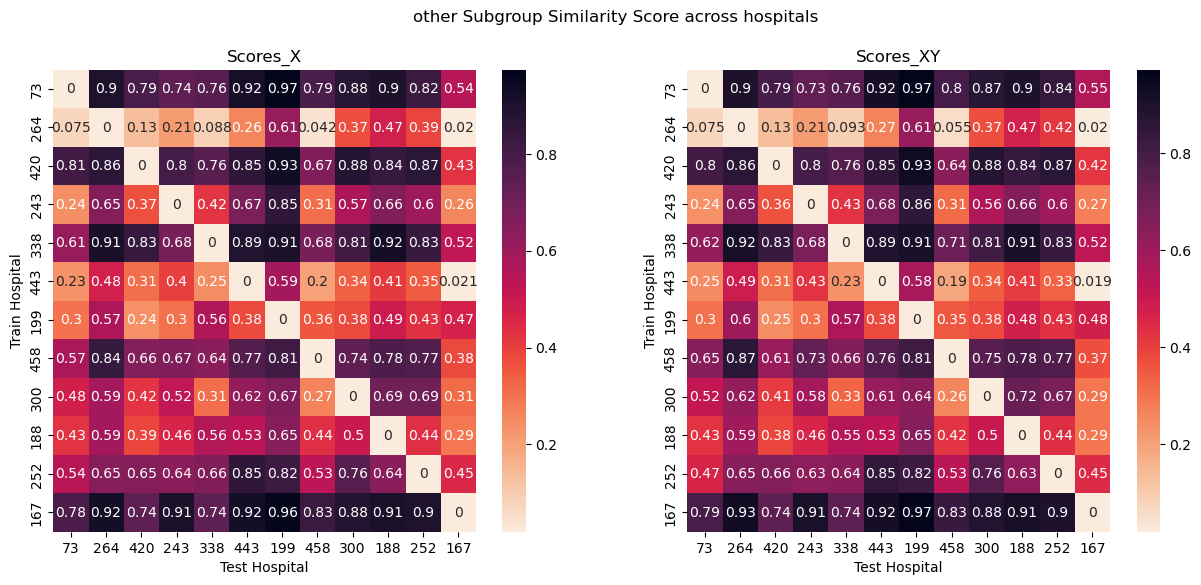

In [12]:
subgroup = "other"
results_x, results_xy = compute_binary_subgroup_score(subgroup, hospital_ids, "/home/tane/YAIB/YAIB/results/distances")

plot_subgroup_score_heatmaps(results_x, results_xy, subgroup)

# visualizations

In [13]:
model = "LogisticRegression"
metric = "AUC"

dist_shift_avg = np.load(f"../results/dist_shift/{model}-avg.npz") 
add_data_avg = np.load(f"../results/add_data/{model}-avg.npz")
add_data_std = np.load(f"../results/add_data/{model}-std.npz")
add_subgroup_avg = np.load(f"../results/add_subgroup/{model}-avg.npz")
add_subgroup_std = np.load(f"../results/add_subgroup/{model}-std.npz")

auc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*AUC.*').match(metric)]

base_columns = ['hosp_id', 'count', 'AUC']

In [14]:
black_score_x = np.load(f"../results/distances/black-score-x.npy")
black_score_xy = np.load(f"../results/distances/black-score-xy.npy")

white_score_x = np.load(f"../results/distances/white-score-x.npy")
white_score_xy = np.load(f"../results/distances/white-score-xy.npy")

other_score_x = np.load(f"../results/distances/other-score-x.npy")
other_score_xy = np.load(f"../results/distances/other-score-xy.npy")

In [15]:
diff = add_data_avg[metric] - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T

np.fill_diagonal(diff, 0)

In [16]:
plot_df = pd.DataFrame()
plot_df[f'{model}-base-{metric}'] = np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()
plot_df[f'{model}-add_data-{metric}'] = add_data_avg[metric].flatten()
plot_df[f'{model}-add_data-{metric}-std'] = add_data_std[metric].flatten()
plot_df[f'{model}-add_data-{metric}-diff'] = plot_df[f'{model}-add_data-{metric}'] - plot_df[f'{model}-base-{metric}']

for i in range(4):
    plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"] = np.repeat(np.diagonal(dist_shift_avg[f'race{i}_{metric}_TEST']).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}"] = add_data_avg[f"race{i}_{metric}_TEST"].flatten()
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}-std"] = add_data_std[f"race{i}_{metric}_TEST"].flatten()
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}"] = add_subgroup_avg[f"race{i}_{metric}_TEST"].flatten()
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}-std"] = add_subgroup_std[f"race{i}_{metric}_TEST"].flatten()
    
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}-diff"] = plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}"] - plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"]
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}-diff"] = plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}"] - plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"]
    
plot_df['black-score-x'] = black_score_x.flatten()
plot_df['black-score-xy'] = black_score_xy.flatten()

plot_df['other-score-x'] = other_score_x.flatten()
plot_df['other-score-xy'] = other_score_xy.flatten()

plot_df['white-score-x'] = white_score_x.flatten()
plot_df['white-score-xy'] = white_score_xy.flatten()

plot_df['train_hospital'] = np.repeat(hospital_ids, repeats=len(hospital_ids))
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(np.array(hospital_ids).reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

In [17]:
def plot_scatterplot_by_train_hosp(plot_df, x, y):
    plot_df = plot_df[(plot_df[x] != 0) & (plot_df[y] != 0)]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatterplot with hue and style for 'train_hospital'
    sns.scatterplot(data=plot_df, x=x, y=y, 
                    hue='train_hospital', style='train_hospital', s=150, ax=ax)

    # Add a regression line without scatter points
    sns.regplot(x=x, y=y, data=plot_df, 
                scatter=False, color='silver', ax=ax)

    # Compute correlation coefficient and p-value
    corr_coef, p_value = pearsonr(plot_df[x], plot_df[y])

    # Add correlation coefficient and p-value text on the plot
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')

    # Customize legend position and title
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
    leg.set_title('Train\nHospital', prop={'size': 16})

    # Set axis labels and title
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'{x} vs. {y}')

    # Save the plot
#     plt.savefig(f'figures/dataadd_ood_auc_{model}.pdf', bbox_inches='tight')
    plt.show()

    # Print correlation details
#     print(f'{subgroup} Similarity Score-X vs. Data-Addition Correlation')

def plot_scatterplot_by_test_hosp(plot_df, x, y):
    plot_df = plot_df[(plot_df[x] != 0) & (plot_df[y] != 0)]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define 12 unique colors and markers
    unique_values = plot_df['test_hospital'].nunique()
    palette = sns.color_palette("husl", unique_values)  # Creates 12 unique colors
    markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']  # 12 unique markers
    
    correlation_dict = {}
    for test_hospital, group in plot_df.groupby('test_hospital'):
        if len(group) > 1:  # Ensure there are enough data points to compute correlation
            corr_coef, _ = pearsonr(group[x], group[y])
            correlation_dict[test_hospital] = corr_coef
        else:
            correlation_dict[test_hospital] = np.nan  # Not enough points for correlation

    # Scatterplot with hue and style for 'test_hospital'
    sns.scatterplot(data=plot_df, x=x, y=y, 
                    hue='test_hospital', style='test_hospital', 
                    palette=palette, markers=markers, s=150, ax=ax)

    # Add a regression line without scatter points
    sns.regplot(x=x, y=y, data=plot_df, 
                scatter=False, color='silver', ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        # Parse test_hospital label and add correlation coefficient
        try:
            test_hospital = int(label)  # Convert label to integer to match test hospital IDs
            corr_coef = correlation_dict.get(test_hospital, np.nan)
            new_label = f'{label} (r={corr_coef:.2f})'
        except ValueError:
            new_label = label  # For labels that aren’t test hospitals
        new_labels.append(new_label)

    
    # Compute correlation coefficient and p-value
    corr_coef, p_value = pearsonr(plot_df[x], plot_df[y])

    # Add correlation coefficient and p-value text on the plot
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')

    # Customize legend position and title
    ax.legend(handles=handles, labels=new_labels, loc='center left', 
              bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14).set_title('Anchor\nHospital', prop={'size': 16})

    # Set axis labels and title
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'{x} vs. {y}')

    plt.show()

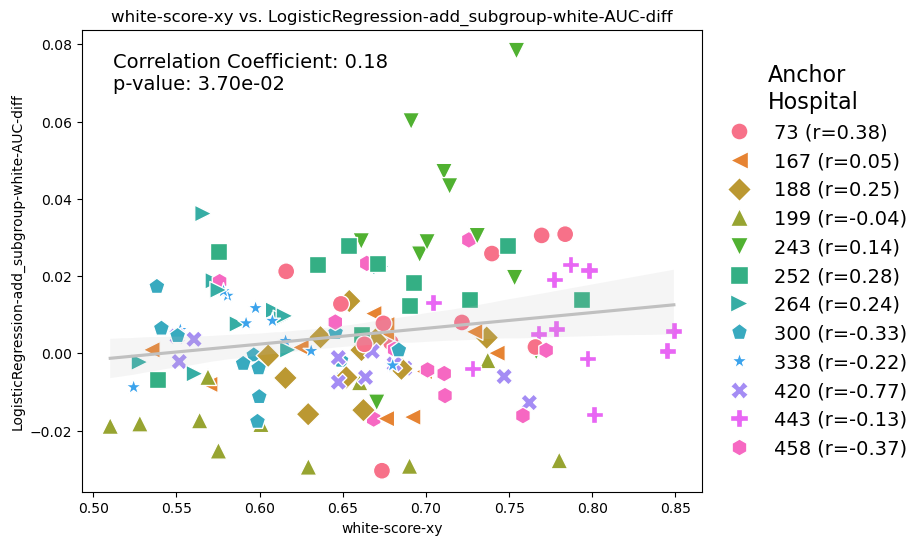

In [47]:
plot_scatterplot_by_test_hosp(plot_df, x="white-score-xy", y="LogisticRegression-add_subgroup-white-AUC-diff")

/tmp/ipykernel_1616495/2431098277.py:57: UserWarning: The markers list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data=plot_df, x=x, y=y,


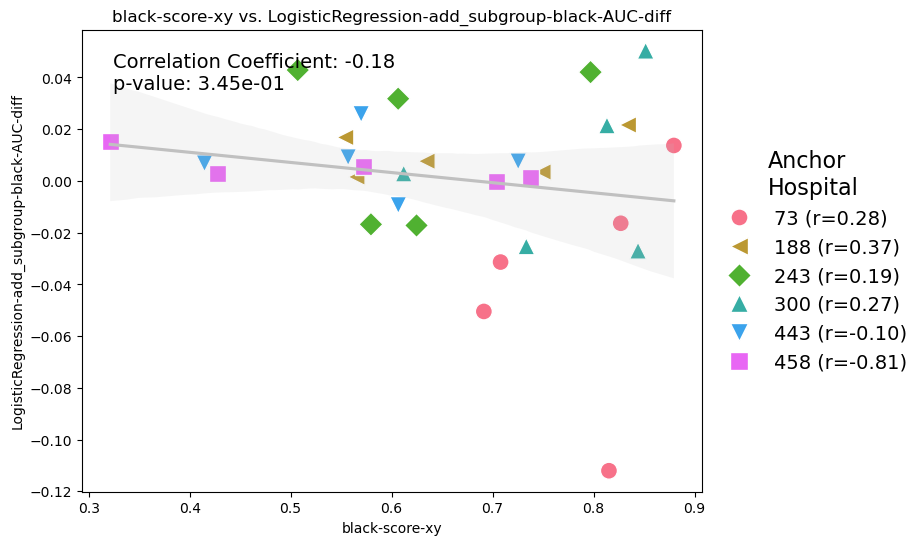

In [24]:
black_hosp_thresh_str = ["73", "188", "243", "300", "443", "458"]
black_hosp_thresh = [73, 188, 243, 300, 443, 458]
plot_df_black = plot_df[(plot_df['train_hospital'].isin(black_hosp_thresh_str)) & (plot_df['test_hospital'].isin(black_hosp_thresh))]

plot_scatterplot_by_test_hosp(plot_df_black, x="black-score-xy", y="LogisticRegression-add_subgroup-black-AUC-diff")

/tmp/ipykernel_1616495/2431098277.py:57: UserWarning: The markers list has more values (12) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x=x, y=y,


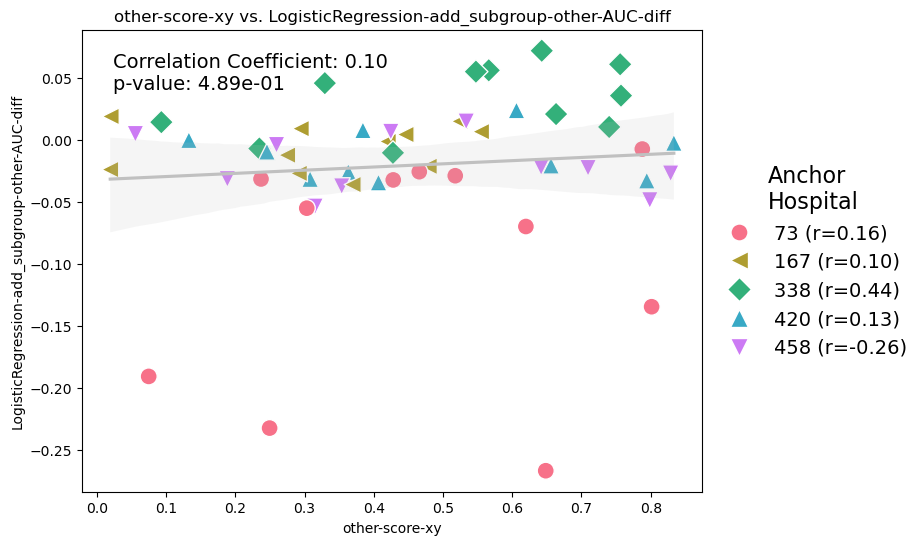

In [26]:
other_hosp_thresh_str = ["73", "167", "338", "420", "458"]
other_hosp_thresh = [73, 167, 338, 420, 458]
plot_df_other = plot_df[(plot_df['test_hospital'].isin(other_hosp_thresh))]

plot_scatterplot_by_test_hosp(plot_df_other, x="other-score-xy", y='LogisticRegression-add_subgroup-other-AUC-diff')